# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

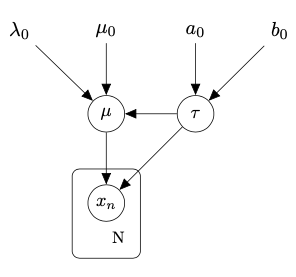

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [210]:
import numpy as np
from scipy import stats
from scipy.special import digamma, gammaln
import matplotlib.pyplot as plt

In [211]:
def generate_data(mu, tau, N):
  np.random.seed(0)
  D = np.random.normal(mu, 1/np.sqrt(tau), N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



In [212]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here

plt.hist(dataset_1, bins=30, alpha=0.5, label='N=10')
plt.savefig('Report/figures/1.2/dataset_1.png')
plt.clf()
plt.hist(dataset_2, bins=30, alpha=0.5, label='N=100')
plt.savefig('Report/figures/1.2/dataset_2.png')
plt.clf()
plt.hist(dataset_3, bins=30, alpha=0.5, label='N=1000')
plt.savefig('Report/figures/1.2/dataset_3.png')
plt.clf()


<Figure size 640x480 with 0 Axes>

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [213]:
def ML_est(data):
  return np.mean(data), 1/np.var(data)

In [214]:
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))


(2.043722377390312, 0.5346208711845316)
(1.0845813067074894, 0.49220998007161765)
(0.9359973504790137, 0.513223482048345)


### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [215]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):

    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    lambda_N = lambda_0 + N
    mu_N = (lambda_0 * mu_0 + N * x_bar) / lambda_N
    a_N = a_0 + N / 2
    b_N = b_0 + 0.5 * sum_squared_diffs + (lambda_0 * N * (x_bar - mu_0) ** 2) / (2 * lambda_N)

    return a_N, b_N, mu_N, lambda_N


### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [216]:
# prior parameters
mu_0 = 0
lambda_0 = 0.1
a_0 = 0.1
b_0 = 0.1

Continue with a helper function that computes ELBO:


In [217]:

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    
    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    E_tau = a_N / b_N
    E_log_tau = digamma(a_N) - np.log(b_N)

    term1 = 0.5 * N * (E_log_tau - np.log(2 * np.pi)) - 0.5 * E_tau * (
        sum_squared_diffs + N * (x_bar - mu_N) ** 2 + (1 / lambda_N)
    )

    term2 = 0.5 * (E_log_tau - np.log(2 * np.pi / lambda_0)) - 0.5 * E_tau * (
        lambda_0 * (mu_N - mu_0) ** 2 + (1 / lambda_N)
    )

    term3 = a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau

    entropy_q_mu = 0.5 * np.log(2 * np.pi * np.e / (lambda_N * E_tau))

    entropy_q_tau = a_N - np.log(b_N) + gammaln(a_N) + (1 - a_N) * digamma(a_N)

    elbo = term1 + term2 + term3 + entropy_q_mu + entropy_q_tau

    return elbo



Now, implement the CAVI algorithm:

In [218]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=100, tol=1e-6):
    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    E_tau = a_0 / b_0

    mu_N = mu_0
    lambda_N = lambda_0
    a_N = a_0
    b_N = b_0

    elbos = []
    prev_elbo = -np.inf

    for iteration in range(max_iter):
        lambda_N = lambda_0 + N * E_tau
        mu_N = (lambda_0 * mu_0 + N * E_tau * x_bar) / lambda_N

        a_N = a_0 + (N + 1) / 2
        b_N = b_0 + 0.5 * (
            sum_squared_diffs + N * (x_bar - mu_N) ** 2 + (1 / lambda_N) + lambda_0 * (mu_N - mu_0) ** 2
        )

        E_tau = a_N / b_N
        E_log_tau = digamma(a_N) - np.log(b_N)

        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)

        if np.abs(elbo - prev_elbo) < tol:
            print(f"Converged at iteration {iteration + 1}")
            break
        prev_elbo = elbo

    return a_N, b_N, mu_N, lambda_N, elbos


Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


In [219]:
def plot_cavi_elbo(dataset):
    _,_,_,_, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0, max_iter=1000, tol=1e-12)

    print(len(elbos))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(0, len(elbos)), elbos, label='ELBO', color='blue', marker='o', linestyle='-')
    ax.set_xlabel('Iteration')
    ax.set_xticks(np.arange(min(range(0, len(elbos))), max(range(0, len(elbos))) + 1, 1))  # Set x-axis to display only integer values
    ax.set_ylabel('ELBO')
    ax.set_title('ELBO vs Iteration')
    ax.grid(True, which="both", ls="--")
    ax.legend()
        
    return fig

In [220]:
fig = plot_cavi_elbo(dataset_1)
fig.savefig('Report/figures/1.2/elbos_d1.png')
plt.clf()
fig = plot_cavi_elbo(dataset_2)
fig.savefig('Report/figures/1.2/elbos_d2.png')
plt.clf()
fig = plot_cavi_elbo(dataset_3)
fig.savefig('Report/figures/1.2/elbos_d3.png')
plt.clf()


Converged at iteration 8
8


Converged at iteration 5
5
Converged at iteration 4
4


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [221]:
def plot_contour(dataset, x_min =0, x_max=3, y_min=0, y_max=1.5):
    x = np.linspace(x_min, x_max, 500)
    y = np.linspace(y_min, y_max, 500)
    X, Y = np.meshgrid(x, y)
    a_ex, b_ex, mu_ex, lambda_ex = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)
    Z_ex = stats.norm.pdf(X, mu_ex, scale=1/np.sqrt(lambda_ex)) * stats.gamma.pdf(Y, a_ex, scale=1/b_ex)

    a_CAVI, b_CAVI, mu_CAVI, lambda_CAVI, _ = CAVI(dataset, a_0, b_0, mu_0, lambda_0)
    Z_CAVI = stats.norm.pdf(X, mu_CAVI, scale=1/np.sqrt(lambda_CAVI)) * stats.gamma.pdf(Y, a_CAVI, scale=1/b_CAVI)

    mu_ml, tau_ml = ML_est(dataset)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contour(X, Y, Z_ex, colors='red', alpha=0.5)
    ax.contour(X, Y, Z_CAVI, colors='blue', alpha=0.5)
    
    # Add dummy plots for the legend
    ax.plot([], [], color='red', label='Exact Posterior')
    ax.plot([], [], color='blue', label='CAVI Posterior')
    
    # Scatter plot with higher zorder
    ax.scatter(mu_ml, tau_ml, color='green', label='ML estimate', zorder=5)
    
    ax.set_xlabel('mu')
    ax.set_ylabel('tau')
    ax.set_title('Posterior Distribution')
    ax.legend()
    ax.grid(True, which="both", ls="--")
    
    
    return fig

In [222]:
plot_contour(dataset_1, 1,3,0,1.5)
plt.savefig('Report/figures/1.2/contour_d1.png')
plt.clf()
plot_contour(dataset_2, 0.5, 1.5, 0,1)
plt.savefig('Report/figures/1.2/contour_d2.png')
plt.clf()
plot_contour(dataset_3, 0.5, 1.5, 0.25, 0.75)
plt.savefig('Report/figures/1.2/contour_d3.png')
plt.clf()

Converged at iteration 5
Converged at iteration 4
Converged at iteration 3


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>